# Simple-GP-RHM

This notebook implements a slightly more complex scenario where the Simple-GP-RHM tracker will be applied. For an introductory first scenario, please refer to the previous notebook (TODO: hyperlink).

In this scenario, the object will be a cross-shaped moving target. Measurements will be generated from the entire object surface rather than just the object contour.

This notebook follows the same structure as previous one.

In [1]:
# import packages
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import itertools

# --- Matplotlib settings:
plt.rc('legend', fontsize=10, handlelength=2)  # legend size
plt.rc('font', size=12)  # fontsize

# colors:
c_gt = 'g'  # color for ground truth
c_meas = 'purple'  # color for measurements
c_est = 'b'  # color for estimates

## Data generation

The modelled situation in this example is slightly more complex than in the previous notebook.

The target object is a cross of two axis-aligned rectangles with the same center. It is moving along the x-Axis with a certain velocity, following a simple time-discretized constant velocity model with zero-mean white noise acceleration applied.

In this part, data for this model will be generated and visualized.

First of all, the parameters for the object and measurements need to be set:

In [2]:
# --- object initialization: 
# the center of the two rectangles of the cross is shared between both 
# these are the initial coordinates
object_center_x = 0
object_center_y = 0
# length and width are 2D, because they describe length and width of the two rectangles defining the cross
object_length = [3.5, 1]  # x axis
object_width = [1, 2.5] # y axis

# velocity[m/s] (in x direction to preserve the simple model)
object_velocity = 0.2

# --- object is moving: add a nearly constant velocity model x_k+1 = F @ x + J * w_proc 
# time step length t[s]
t = 1

# motion model F
F = np.array([
    [1, 0, t],
    [0, 1, 0],
    [0, 0, 1]
])

# zero mean white noise acceleration with variance w_proc
w_proc = 0.1

J = np.array([
    [t**2/2, 0, t]
]).T

# Kalman filter process noise Q
Q = w_proc * np.array([
    [t**4/4, 0 , t**3/2],
    [0, 0, 0],
    [t**3/2, 0, t**2]
])

# --- measurements:
# mean number of detections y from the object in each step 
lambda_y = 50
# each true measurement source y will be a 2D vector containing x- and y-position
# covariance of p(z|y) = N(z; y, R)
R = np.eye(2)*0.01


# --- ensure format of parameters is correct
assert R.shape == (2,2), "R needs to be of shape (2,2)"
assert F.shape == (3,3), "F needs to be of shape (3,3)"
assert Q.shape == (3,3), "Q needs to be of shape (3,3)"
assert J.shape == (3,1), "J needs to be shape (3,1)"

# --- set up global constants for implementation
N_STEPS = 10  # how many steps to run the simulation for
RNG = default_rng(42)  # numpy random generator 

---
Measurements are drawn from the entire cross surface, using accept-reject sampling.

In [3]:
def cross_accept_reject(loc, xl, yl, n_pts):
    """Use Accept/Reject sampling strategy to get n points from a cross specified by loc, xl and yl"""
    samples = []
    while len(samples) < n_pts:
            # get x/y coords from hull of cross
            x = RNG.uniform(low=loc[0] - max(xl) / 2, high=loc[0] + max(xl) / 2)
            y = RNG.uniform(low=loc[1] - max(yl) / 2, high=loc[1] + max(yl) / 2)
            # if [x, y] is in either rectangle of the cross, accept the sample
            in_r1 = loc[0]-xl[0]/2 <= x <= loc[0]+xl[0]/2 and loc[1]-yl[0]/2 <= y <= loc[1]+yl[0]/2
            in_r2 = loc[0]-xl[1]/2 <= x <= loc[0]+xl[1]/2 and loc[1]-yl[1]/2 <= y <= loc[1]+yl[1]/2
            if in_r1 or in_r2:
                samples.append([x, y])
            
    return np.array(samples)

# ---
# Use the above function to generate measurements from object surface:
# ---
object_states = [np.array([object_center_x, object_center_y, object_velocity])]  # ground truth states
y = []  # measurement sources
z = []  # received measurements
# use the above function to draw the corresponding measurements
for i in range(N_STEPS):
    state = np.array(object_states[-1]).T
    n_measurements = RNG.poisson(lam=lambda_y)  # number of sources is poisson distributed with mean as specified above
    y_pos_x, y_pos_y = cross_accept_reject([state[0], state[1]], object_length, object_width, n_pts=n_measurements).T  # get measurement source
    
    y_i = np.vstack([y_pos_x, y_pos_y]).T  #  current measurement sources to y, in shape (n_measurements, 2)
    y.append(y_i)
    # second: draw measurements z_i from y_i
    z_i = []
    for y_i_k in y_i:  # treat each measurement k = 0...n_measurements-1 independently
        z_i_k = RNG.multivariate_normal(mean=y_i_k, cov=R)  # p(z|y) = N(z; y, R)
        z_i.append(z_i_k)
    z_i = np.array(z_i)
    assert z_i.shape == y_i.shape, "Mismatch between z and y shape"
    z.append(z_i)
    
    # apply the motion model
    next_state = F @ state + (J * w_proc * RNG.standard_normal()).reshape((3,))
    object_states.append(next_state.reshape((3)))
    
    print("Step: {}/{} - Number of Measurements generated: {}".format(i+1, N_STEPS, n_measurements))

Step: 1/10 - Number of Measurements generated: 56
Step: 2/10 - Number of Measurements generated: 56
Step: 3/10 - Number of Measurements generated: 55
Step: 4/10 - Number of Measurements generated: 48
Step: 5/10 - Number of Measurements generated: 49
Step: 6/10 - Number of Measurements generated: 57
Step: 7/10 - Number of Measurements generated: 53
Step: 8/10 - Number of Measurements generated: 45
Step: 9/10 - Number of Measurements generated: 47
Step: 10/10 - Number of Measurements generated: 56


---
#### Visualize Measurements
Define some necessary functions for plotting and then plot each time step individually.

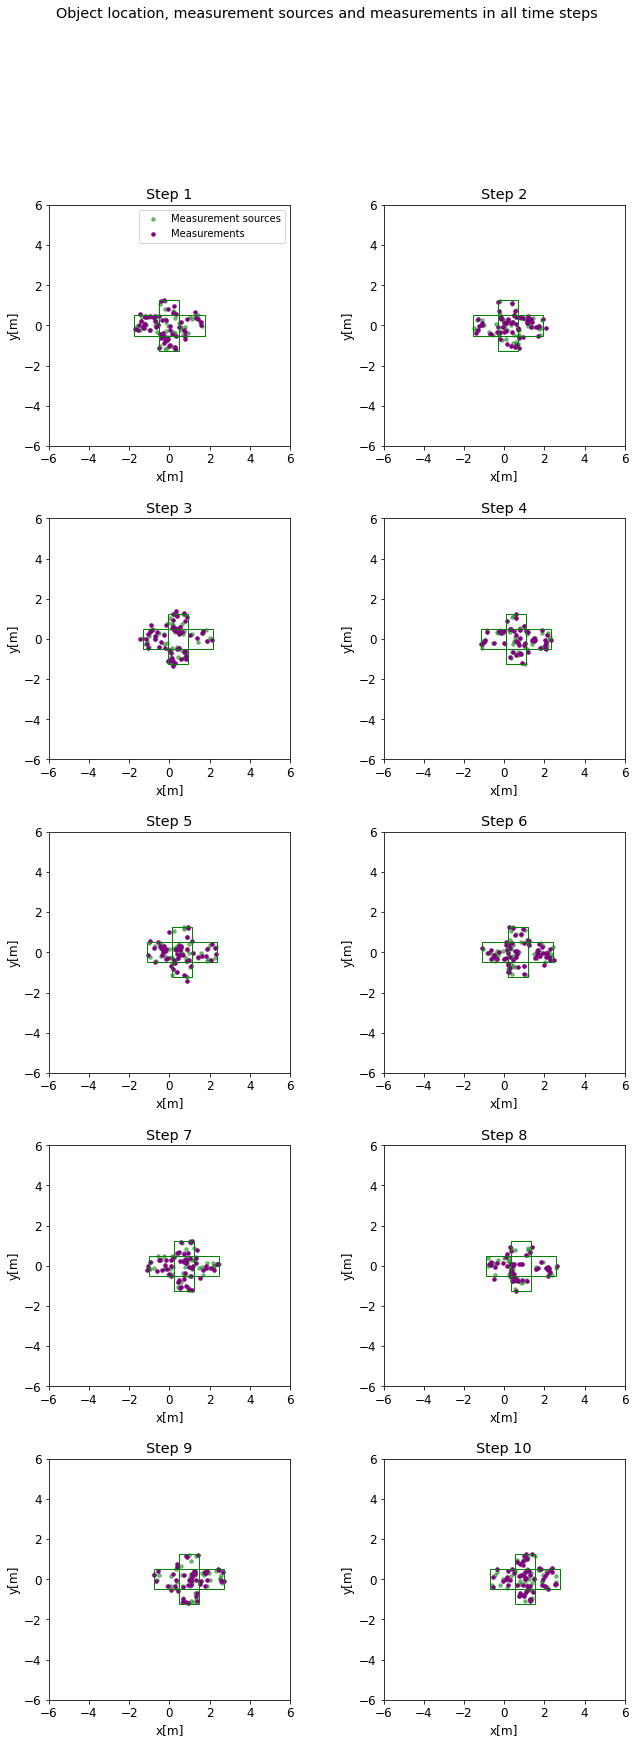

In [4]:
def plot_cross(loc, xl, yl, c='b', ax=None):
    ax = plt.gca() if ax is None else ax
    patch1 = patches.Rectangle((loc[0] - xl[0] / 2, loc[1] - yl[0] / 2), xl[0], yl[0], linewidth=1, edgecolor=c, facecolor='none')
    patch2 = patches.Rectangle((loc[0] - xl[1] / 2, loc[1] - yl[1] / 2), xl[1], yl[1], linewidth=1, edgecolor=c, facecolor='none')
    ax.add_patch(patch1)
    ax.add_patch(patch2)
    
def plt_square(loc, l, ax=None, label_as_m=True):
    """
    Helper function to quickly focus a plot on a location loc with margins l to all sides.
    Can either pass an axis object, or uses the current axis (plt.gca())
    By default also sets axis labeling to 'x[m]' and 'y[m]'
    """
    if ax is None:
        ax = plt.gca()
    ax.set_xlim(loc[0] - l, loc[0] + l)
    ax.set_ylim(loc[1] -l, loc[1] + l)
    ax.set_aspect('equal', adjustable='box')
    
    if label_as_m:
        ax.set_xlabel("x[m]")
        ax.set_ylabel("y[m]")

fig, all_ax = plt.subplots(nrows=int(N_STEPS / 2), ncols=2, figsize=(11, 5.5*int(N_STEPS/2)))
plt.subplots_adjust(hspace=0.3)
for i in range(N_STEPS):
    row = int(i/2)  # row for plots
    col = i % 2  # col for plots
    ax = all_ax[row][col]
    plot_cross([object_states[i][0], object_states[i][1]], object_length, object_width, c=c_gt, ax=ax)
    ax.set_title("Step {}".format(i+1))
    ax.scatter(y[i][:, 0], y[i][:, 1], c=c_gt, label="Measurement sources", s=12, alpha=0.5)
    ax.scatter(z[i][:, 0], z[i][:, 1], c=c_meas, label="Measurements", s=12)
    
    plt_square([object_center_x, object_center_y], 6, ax)
    
    if i == 0:
        ax.legend()
plt.suptitle("Object location, measurement sources and measurements in all time steps")
plt.show()

---
## Simple-GP-RHM

The Simple-GP-RHM algorithm is defined as before. Since the object is moving, in this example the predict step will not be skipped. 

The following cells define the relevant variables for the GP:

In [5]:
# DEFINE VARIABLES FOR Simple-GP-RHM

# define H
dim_m = 3  # dimension of the kinematic state: 3 (x,y,speed) 
H = np.hstack([np.eye(2), np.zeros((2, dim_m-2))])

# scaling parameters
# TODO reference values from paper
s_hat = 2/3#0.8  
sigma_squared_s = 1/18  

# kernel parameters sigma and l:
sigma_squared_ker = 2
l_ker = np.pi / 4

# number of base points (i.e. size of 'p')
num_base_pts = 10

# define base points phi_1..phi_n 
phi_pts = np.linspace(start=0, stop=2*np.pi, num=num_base_pts, endpoint=False)

# new parameter alpha used for extent estimate covariance predict
alpha = 0.001

In [6]:
# DEFINE FUNCTIONS USED BY Simple-GP-RHM

def k(phi_1, phi_2):
    """
    Kernel of the Gaussian process. Here defined as in equation (43)
    """
    d = np.abs(phi_1 - phi_2)
    expo = 2 * np.sin((1/2) * d)**2
    expo /= l_ker**2
    return sigma_squared_ker * np.exp(-expo)
    
def u(phi):
    """
    Function u(phi) as defined in equation (36): Given an input angle phi, returns [cos(phi) sin(phi)]^T
    """
    u = np.array([np.cos(phi), np.sin(phi)])
    u = np.reshape(u, (2, -1))  
    return u


def angle(x, y):
    """
    Given two two dimensional vectors x and y, calculates the angle between them (in radians, from 0 to 2*pi).
    """
    x = np.array(x)
    y = np.array(y)
    x = x /np.linalg.norm(x)
    y = y / np.linalg.norm(y)
    dot = x @ y
    det = x[0] * y[1] - x[1] * y[0]
    a = np.arctan2(det, dot)
    a = (a+2*np.pi) % (2*np.pi)  # cast into [0, 2*pi] 
    a = 2 * np.pi - a  # "flip" so we go clockwise instead of counter-clockwise
    return a

def K(phi):
    """
    K(phi) as defined in equation (45)
    """
    K = np.array([k(phi, phi_n) for phi_n in phi_pts])
    K = np.reshape(K, (-1, len(K)))  
    return K

# define K_p, and invert it (K_p_inv) for later use
# given in equation (42)
K_p = [[k(phi_pts[i], phi_pts[j]) for i in range(len(phi_pts))] for j in range(len(phi_pts))]
K_p = np.array(K_p).T  # transpose because of the order above, but K is symmetric anyway
K_p_inv = np.linalg.inv(K_p)


# use K_p_inv for the definition of A(phi)

def A(phi):
    """
    A(phi) as defined in equation (47)
    """
    if not isinstance(phi+0.0, float):
        # unpack phi to scalar if necessary:
        phi = phi[0]
    A = K(phi) @ K_p_inv
    return A

# ----
def C_e(phi):
    """Given in equation (48)"""
    C = k(phi, phi) - K(phi) @ K_p_inv @ K(phi).T
    return C

def update_gp(z, m_minus, p_minus, C_m_minus, C_p_minus):
    """
    Perform an update for the Simple-GP-RHM Filter, according to Table IV.
    
    Necessary parameters are a measurement z and prior estimates m_minus, p_minus, C_m_minus, C_p_minus
    
    Returns updated estimates m_plus, p_plus, C_m_plus, C_p_plus
    """
    phi = angle(z - H @ m_minus, u(0))
    B_phi = s_hat * (u(phi) @ A(phi))
    
    if sigma_squared_s != 0:
        C_w = sigma_squared_s * ((u(phi) @ A(phi)) @ C_p_minus @ (u(phi) @ A(phi)).T) + sigma_squared_s * u(phi) @ C_e(phi) @ u(phi).T + R
    else:
        # formula simplifies significantly!
        C_w = R
    
    C_z = (B_phi @ C_p_minus @ B_phi.T) + H @ C_m_minus @ H.T + C_w
    C_mz = C_m_minus @ H.T
    C_pz = C_p_minus @ B_phi.T

    z_bar = B_phi @ p_minus + (H@m_minus).reshape((2,1))
    # invert C_z once here
    C_z_inv = np.linalg.inv(C_z)
    
    m_plus = m_minus + ( C_mz @ C_z_inv @ (z.reshape((2,1)) - z_bar).reshape(2) )
    C_m_plus = C_m_minus - ( C_mz @ C_z_inv @ C_mz.T)

    # in order to calculate p_plus, we need to reshape parts of the equation for numpy, so split it up in two parts for readability:
    p_add = ( C_pz @ C_z_inv @ (z.reshape((2,1)) - z_bar))  # calculate necessary part
    p_add = np.reshape(p_add, (len(p_add), -1))  # reshape to make sure numpy adds everything correctly
    p_plus = p_minus + p_add  # finalize p_plus
    
    C_p_plus = C_p_minus - ( C_pz @ C_z_inv @ C_pz.T)
    
    return m_plus, p_plus, C_m_plus, C_p_plus


def predict(m, p, C_m, C_p, F, Q, alpha):
    """
    Standard Kalman Filter predict for the state m with covariance C_m, motion model F and process noise covariance Q.
    For the extent estimate p, the covariance is increased by alpha*Identity
    """
    m = F @ m
    C_m = F @ C_m @ F.T + Q
    C_p = C_p + alpha*np.eye(C_p.shape[0])
    return m, p, C_m, C_p

In [7]:
# DEFINE UTILITY FUNCTIONS FOR VISUALIZATION

def pol2cart(rho, phi):
    """
    Help function to convert from polar(radius rho, angle phi) to cartesian coordinates.
    """
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)
    
def plot_extent(m, p, n_pts=100):
    """
    Plot the extent of a target specified by state m and base points p.
    
    The plot is added to the current axis, which you can select using for example `plt.sca(<axis object>)`
    
    n_pts specifies how many points to use for the plot, essentially the angular resolution
    c specifies the plot color
    """
    # make sure format is as desired
    p = p.reshape((len(p),))
    m = m.reshape((len(m),))
    
    # get the angles including overlap on the last one (endpoint=True) to prevent a "hole" in the visualization 
    scatter_angles = np.linspace(0, 2*np.pi, n_pts, endpoint=True)
    
    # use equation (52) to get to cartesian points at desired angles
    ex = np.array([s_hat * u(phi) @ A(phi) @ p + H @ m for phi in scatter_angles])
    
    # plot the result
    plt.gca().plot(ex[:, 0], ex[:, 1], c=c_est, label="Extent Estimate")
    plt.gca().scatter(m[0], m[1], c=c_est, marker='x', label="Location Estimate")

    
def plot_radial_fct(p, n_pts=100):
    """
    Plot the radial function estimate based on basis points p. Granularity can be set using parameter n_pts.
    """
    x = np.linspace(0, 2*np.pi, n_pts, endpoint=False)
    y = [A(phi) @ p for phi in x]
    plt.gca().plot(x, y, label="Radial Function")
    plt.gca().set_ylim(0, max(y)+0.5)  # make sure y-axis starts at 0 and covers everything

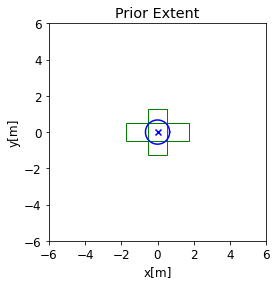

In [8]:
# basis points p with covariance C_p
# state m with covariance C_m
m_init = np.array([0, 0, 0]) * 1.0  # position 0,0 and velocity 0 too
C_m_init = np.eye(3)*0.01
p_init = np.array([1.0]*num_base_pts)  # start with a circle
C_p_init = np.eye(num_base_pts)


# Take a look at the prior
plt.title("Prior Extent")
plot_cross([object_center_x, object_center_y], object_length, object_width, c=c_gt)
plot_extent(m_init, p_init)
plt_square([object_center_x, object_center_y], 6)
plt.show()

### Simple-GP-RHM tracking

With all necessary functions defined, the algorithm can now be applied to the data.

In [9]:
# Arrays to store intermediate results:
m_list = []
Cm_list = []
p_list = []
Cp_list = []

# Initial values:
m = m_init
C_m = C_m_init
p = p_init  # start with a circle
C_p = C_p_init

p = np.reshape(p, (len(p), -1))
for i in range(N_STEPS):
    # --- predict
    if i > 0: # skip predict for the first step
        m, p, C_m, C_p = predict(m, p, C_m, C_p, F, Q, alpha)
    
    # --- update
    # get measurements z_i for this step
    z_i = z[i]
    for z_i_k in z_i:  # pass each measurement to update individually
        m, p, C_m, C_p = update_gp(z_i_k, m, p, C_m, C_p)  # update with new measurement
    m_list.append(m)
    Cm_list.append(C_m)
    p_list.append(p)
    Cp_list.append(C_p)

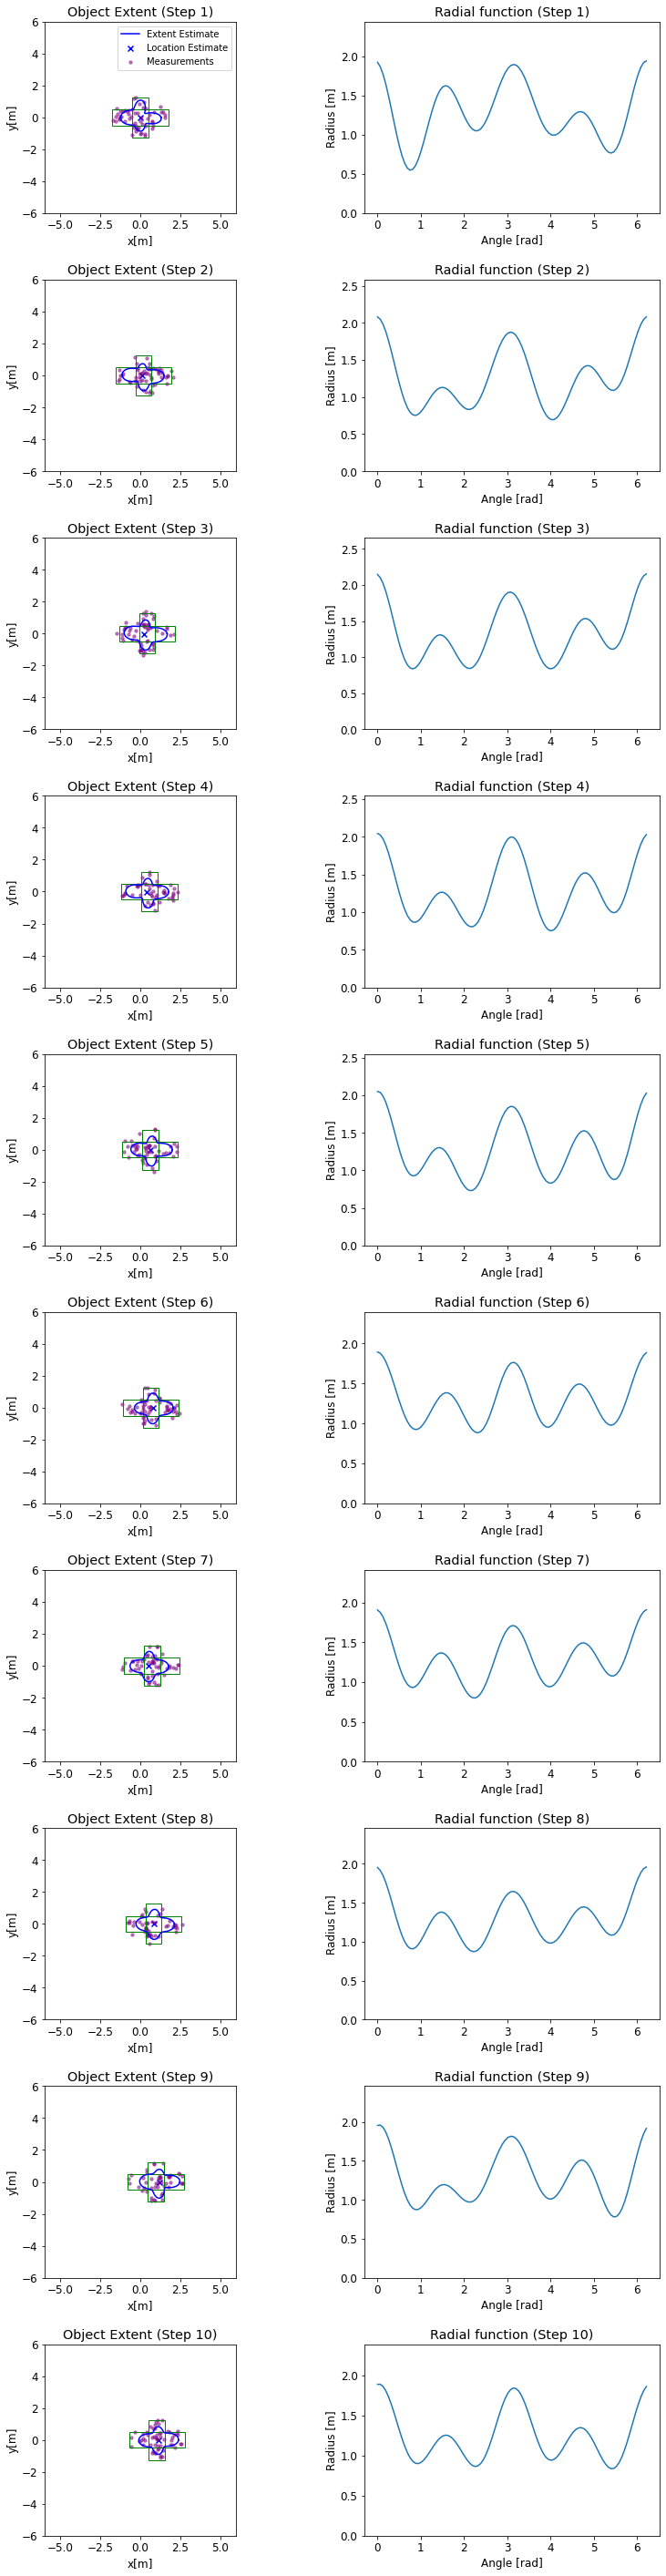

In [10]:
# Visualize each step indivdually:
SIZE = 4  # size parameter for subplots
fig, all_ax = plt.subplots(nrows=int(N_STEPS), ncols=2, figsize=(SIZE*3, SIZE*int(N_STEPS)))
fig.tight_layout(pad=4.0)
for i in range(N_STEPS):
    # --- EXTENT ESTIMATE:
    ax = all_ax[i][0]
    plt.sca(ax)
    plot_extent(m_list[i], p_list[i])
    
    # add ground truth:
    plot_cross([object_states[i][0], object_states[i][1]], object_length, object_width, c=c_gt, ax=ax)
    
    # add measurements 
    ax.scatter(z[i][:, 0], z[i][:, 1], c=c_meas, label="Measurements", alpha=0.5, s=11)
    
    # add title and formatting:
    ax.set_title("Object Extent (Step {})".format(i+1))
    plt_square([object_states[0][0], object_states[0][1]], 6, ax)

    if i == 0:
        ax.legend()
    
    # --- RADIAL FUNCTION:
    ax = all_ax[i][1]
    plt.sca(ax)
    plot_radial_fct(p_list[i].reshape(len(p_list[i]), ))
    ax.set_title("Radial function (Step {})".format(i+1))
    ax.set_xlabel("Angle [rad]")
    ax.set_ylabel("Radius [m]")
plt.show()